The hypothesis is as follows:
We can build a NN for simulating the black scholes option pricing model, to obtain the 'ideal' options price based on some simple parameters. When there is a significant deviation in the real market from this 'ideal' price, we have an arbitrage oppurtunity. This can be checked by looking at the spread between the 'ideal' calculated price and the actual price vs time for a few seconds/minutes. If they converge, then an arbitrage oppurtunity exists, else it doesn't.

Going a level deeper, the hypothesis here is that any intrinsic movement occurs in the stock before the option chain. Thus, for example, if there is any news event which can cause an upward movement in the company, the movement ocurs first in the stock. Now, for some time, there is no corresponding movement in the options. Hence, when using our option price calculation model, we will observe that the real price is at a discount. After some time, the option price will then move up accordingly.

#####

In [ ]:
# imports
import numpy as np
import pandas as pd
import os
import sys
sys.path.insert(1, '../essential_files')
import historical_data as hd

In [ ]:
# To test the hypothesis, we will first look at the correlation between stock and option prices for different time deltas (1 sec, 2 secs, etc.).

# Get banknifty data on 17th May 2024
banknifty_data = hd.get_equity_historical_data(start_date='2024-05-17T09:15:00.000Z', end_date='2024-05-17T16:00:00.000Z', stock_code='CNXBAN', time_interval='1second')
print(banknifty_data.head())

In [ ]:
# Strike of 47900
options_data = hd.get_option_historical_data(start_date = "2024-05-17T09:15:00.000Z", end_date = "2024-05-17T15:30:00.000Z", expiry = "2024-05-22T09:15:00.000Z", strike = 47900, stock_code="CNXBAN", time_interval="1second", right="Call")
print(options_data.head())

In [ ]:
print(banknifty_data.columns)

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the data
data = pd.read_csv(r'C:\Users\Mridul\Documents\New Trading\Data\CNXBAN_1minute2024_05_17.csv')

# Drop columns with all NaN values
data_clean = data.drop(columns=['Unnamed: 0', 'product_type', 'expiry_date', 'right', 'strike_price', 'volume', 'open_interest'])

# Convert 'datetime' column to datetime format
data_clean['datetime'] = pd.to_datetime(data_clean['datetime'])

# Set 'datetime' as the index
data_clean.set_index('datetime', inplace=True)

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_clean[['open', 'high', 'low', 'close', 'count']])

# Define a function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][3]  # 'close' price is at index 3
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # e.g., using the last 60 minutes to predict the next minute
X, y = create_sequences(scaled_data, seq_length)

# Split into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 5)))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and true values to original scale
y_pred_inverse = scaler.inverse_transform(
    np.hstack((np.zeros((y_pred.shape[0], 3)), y_pred, np.zeros((y_pred.shape[0], 1)))))[:, 3]
y_test_inverse = scaler.inverse_transform(
    np.hstack((np.zeros((y_test.shape[0], 3)), y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1)))))[:, 3]

# Plot the predictions against the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='True')
plt.plot(y_pred_inverse, label='Predicted')
plt.legend()
plt.show()


Epoch 1/20


c:\Users\Mridul\anaconda3\envs\yfinance\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.3465 - val_loss: 0.1766
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1207 - val_loss: 0.0403
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0394 - val_loss: 0.0055
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0225 - val_loss: 0.0045
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0187 - val_loss: 0.0043
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0173 - val_loss: 0.0031
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0163 - val_loss: 0.0046
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0165 - val_loss: 0.0037
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0138 - val_loss: 0.0036
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0139 - val_loss: 0.0025
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0151 - val_loss: 0.0030
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0132 - val_l

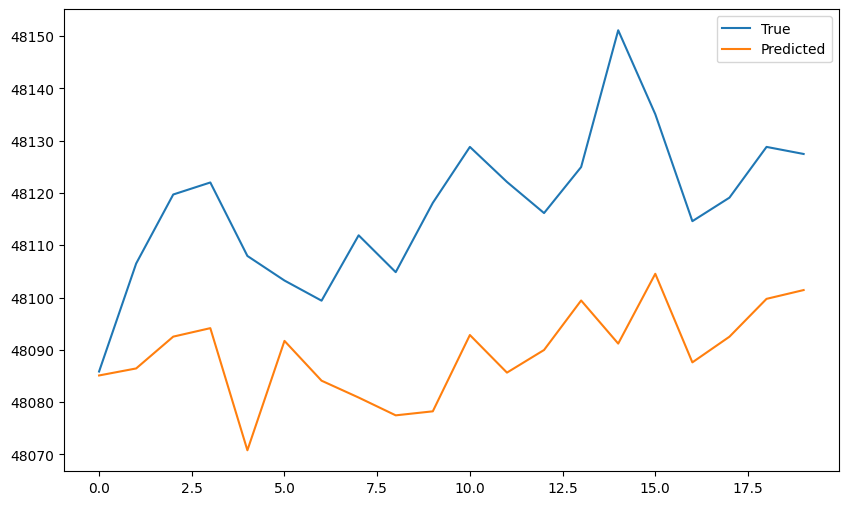

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv(r'C:\Users\Mridul\Documents\New Trading\Data\CNXBAN_1minute2024_05_17.csv')

# Drop columns with all NaN values
data_clean = data.drop(columns=['Unnamed: 0', 'product_type', 'expiry_date', 'right', 'strike_price', 'volume', 'open_interest'])

# Convert 'datetime' column to datetime format
data_clean['datetime'] = pd.to_datetime(data_clean['datetime'])

# Set 'datetime' as the index
data_clean.set_index('datetime', inplace=True)

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_clean[['open', 'high', 'low', 'close', 'count']])

# Define a function to create sequences for predicting the next 20 minutes
def create_sequences(data, seq_length, pred_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - pred_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length:i+seq_length+pred_length, 3]  # 'close' price is at index 3
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # e.g., using the last 60 minutes
pred_length = 20  # predicting the next 20 minutes
X, y = create_sequences(scaled_data, seq_length, pred_length)

# Split into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 5)))
model.add(LSTM(50))
model.add(Dense(pred_length))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and true values to original scale
y_pred_reshaped = y_pred.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Stack with zeros
y_pred_with_zeros = np.hstack((np.zeros((y_pred_reshaped.shape[0], 3)), y_pred_reshaped, np.zeros((y_pred_reshaped.shape[0], 1))))
y_test_with_zeros = np.hstack((np.zeros((y_test_reshaped.shape[0], 3)), y_test_reshaped, np.zeros((y_test_reshaped.shape[0], 1))))

# Inverse transform
y_pred_inverse = scaler.inverse_transform(y_pred_with_zeros)[:, 3].reshape(-1, pred_length)
y_test_inverse = scaler.inverse_transform(y_test_with_zeros)[:, 3].reshape(-1, pred_length)

# Plot the predictions against the actual values for the first instance in the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse[0], label='True')
plt.plot(y_pred_inverse[0], label='Predicted')
plt.legend()
plt.show()


In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 33.50655081381472
Mean Squared Error (MSE): 1604.2501582502182
Root Mean Squared Error (RMSE): 40.053091743961765


In [ ]:
# Extracting relevant columns
cnxban_df = banknifty_data[['datetime', 'close']]
cnxban_options_df = options_data[['datetime', 'close']]

# Renaming columns to avoid confusion
cnxban_df.rename(columns={'close': 'close_cnxban'}, inplace=True)
cnxban_options_df.rename(columns={'close': 'close_options'}, inplace=True)

# Merging dataframes on 'datetime'
merged_df = pd.merge(cnxban_df, cnxban_options_df, on='datetime', how='inner')

# Display the first few rows of the merged dataframe
merged_df.head()


In [ ]:
y1 = merged_df['close_cnxban'].astype(float)
y2 = merged_df['close_options'].astype(float)

In [ ]:
def get_corr(y1, y2, delta):
    # Get correlation coefficient between stock and option prices for a given time delta
    # y1: stock prices
    # y2: option prices
    # delta: time delta in seconds
    if delta>0:
        new_y1 = y1[:-delta]
        new_y2 = y2[delta:]
        
        # print(new_y1, new_y2)

        return np.corrcoef(new_y1, new_y2)[0, 1]
    elif delta <0:
        new_y1 = y1[-delta:]
        new_y2 = y2[:delta]
        # print(new_y1, new_y2)

        return np.corrcoef(new_y1, new_y2)[0, 1]
    else:
        return np.corrcoef(y1, y2)[0, 1]

In [ ]:
for delta in range(-60,60):
    corr = get_corr(y1, y2, delta)
    print(f"Correlation between stock and option prices for delta = {delta} is {corr}")